In [23]:
from scipy.sparse import *
import numpy as np
import pickle
import random
from sklearn.decomposition import PCA
%matplotlib inline
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from operator import itemgetter
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

In [2]:
# load vocabulary
with open('vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)
list(vocab.items())[:10]

[('tgl', 36188),
 ('cutout', 35820),
 ('searching', 4042),
 ('port', 2380),
 ('imaginative', 17609),
 ('20/20', 28163),
 ('waffles', 8813),
 ('starboy', 38363),
 ('projecting', 82135),
 ('12:51', 30460)]

In [3]:
# construct num -> word dict
reverse_dictionary = dict(zip(vocab.values(), vocab.keys()))

In [4]:
# load cooccurence matrix
with open('cooc.pkl', 'rb') as f:
    cooc = pickle.load(f)
cooc.shape

(101299, 101299)

In [5]:
# load embeddings
embeddings = np.load('embeddings.npy')
embeddings.shape

(101299, 20)

In [6]:
# do PCA on embeddings
pca = PCA(n_components=2, svd_solver='arpack').fit_transform(embeddings)
pca.shape

(101299, 2)

100%|██████████| 10129/10129 [00:00<00:00, 12416.96it/s]


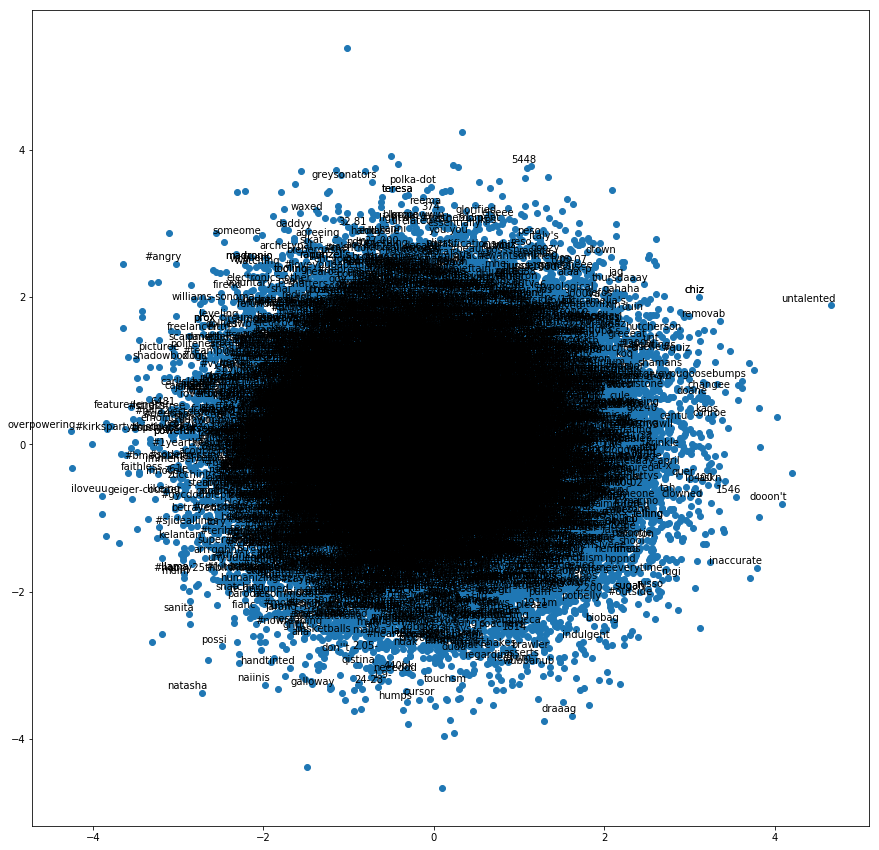

In [7]:
# plot pca
def plot(pca, labels, p = 0.1):
    assert pca.shape[0] == len(labels), 'Labels are not from these embeddings'
    assert pca.shape[1] == 2
    plt.figure(figsize=(15, 15))  # in inches
    plt.scatter(pca[:, 0], pca[:, 1])
    
    labels_subset = np.random.choice(labels, int(len(labels) * p))
    
    for label in tqdm(labels_subset):
        i = vocab[label]
        x, y = pca[i, :]
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    plt.show()

words = list(vocab.keys())
plot(pca, words)

In [8]:
# loading data

In [9]:
# file -> [[word_number_1_1, ..., word_number_1_K1], ..., [word_number_L_1, ..., word_number_L_KL]]
def file_to_word2numbers(filename):
    data = open(filename, 'rb')
    word2numbers_all = []
    for line in tqdm(data):
        line = line.strip().decode("utf-8").split(' ')
        word2numbers = []
        for word in line:
            if word in vocab: word2numbers.append(vocab[word])
        if word2numbers:
            word2numbers_all.append(word2numbers)
    return word2numbers_all

In [10]:
# loading data -> numbers of words
pos_numbers = file_to_word2numbers('pos_train.txt')
neg_numbers = file_to_word2numbers('neg_train.txt')

1250000it [00:12, 101405.91it/s]
1250000it [00:14, 83867.17it/s]


In [26]:
# mean value of features
def numbers_to_dataset(numbers):
    tweets_embeddings = np.zeros((len(numbers), embeddings.shape[1]))
    for i, tweet in enumerate(numbers):
        # mean gave 0.54 even with an NN
        tweets_embeddings[i, :] = np.max(embeddings[tweet, :], axis = 0)
    return tweets_embeddings

In [27]:
# applying it to numbers
pos_data = numbers_to_dataset(pos_numbers)
neg_data = numbers_to_dataset(neg_numbers)

In [28]:
# constructing X, y pair
def two_datasets_to_one(pos_data, neg_data):
    assert pos_data.shape[1] == neg_data.shape[1]
    X = np.vstack((pos_data, neg_data))
    y = np.array([1] * pos_data.shape[0] + [0] * neg_data.shape[0])
    assert len(y) == X.shape[0]
    assert X.shape[0] == pos_data.shape[0] + neg_data.shape[0]
    assert X.shape[1] == pos_data.shape[1]
    return X, y

In [29]:
# applying to datasets (pos & neg)
X, y = two_datasets_to_one(pos_data, neg_data)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
X_train.shape

(1999936, 20)

In [ ]:
# LR gave 0.54 even on full dataset

In [34]:
#idx = np.random.choice(range(X_train.shape[0]), 100000)
idx = list(range(X_train.shape[0]))
#clf = LogisticRegression(verbose=True, n_jobs = 8, solver = 'newton-cg', tol = 1e-4, C = 1e5, max_iter = 100000)
clf = MLPClassifier(solver='lbfgs', alpha=1e-6, hidden_layer_sizes=(100, 50), random_state=1)
clf.fit(X_train[idx,:], y_train[idx])
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.618581794617
0.617454523636


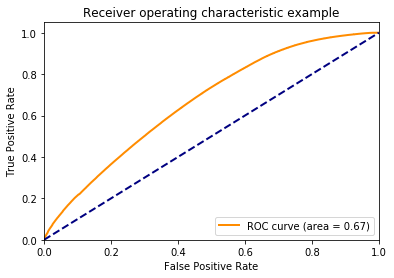

In [35]:
fpr, tpr, _ = roc_curve(y, clf.predict_proba(X)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [36]:
# open train and predict
def test_to_dataset(filename):
    data = open(filename, 'rb')
    idxes = []
    tweets_embeddings = []
    
    for line in tqdm(data):
        idx, line = line.strip().decode("utf-8").split(',', 1)
        idxes.append(idx)
        line = line.split(' ')
        tweet = []
        for word in line:
            if word in vocab: tweet.append(vocab[word])
                
        if len(tweet) > 0:
            tweet_embeddings = np.mean(embeddings[tweet, :], axis = 0)
        else: tweet_embeddings = np.zeros((embeddings.shape[1]))
        tweets_embeddings.append(tweet_embeddings)
        
    #return tweets_embeddings
    tweets_embeddings = np.array(tweets_embeddings)
    assert len(idxes) == tweets_embeddings.shape[0]
    assert tweets_embeddings.shape[1] == embeddings.shape[1]
    return idxes, tweets_embeddings

In [37]:
idx_test, X_test = test_to_dataset('../data/test_data.txt')

10000it [00:00, 31093.93it/s]


In [38]:
y_predicted = np.array(2 * (clf.predict(X_test) - 0.5), dtype=np.int64)

In [39]:
answers = sorted(zip(idx_test, y_predicted), key = lambda x: int(x[0]))

In [40]:
f = open('submission_nn_full_glove.txt', 'w')
f.write("Id,Prediction\n")
for idx, ans in answers:
    f.write("%s,%s\n" % (idx, ans))
f.close()